# Use PINN to learn physical parameters and predict data outside the training range

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

import pickle

np.random.seed(1234)
tf.set_random_seed(1234)

print(tf.__version__)

/home/cw55/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cw55/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cw55/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cw55/anaconda3/envs/tf114/lib/python3.7/site-pack

1.14.0


In [2]:
# define NN
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, T_n, T_s, N_n, N_s, t_data, t_func, layers):
        
        self.lb = min(t_data.min(0),t_func.min(0))
        self.ub = max(t_data.max(0),t_func.max(0))
        
        self.t_0 = tf.constant([[0.0]], dtype=tf.float32) # t=0 initial condition
        self.t_d = t_data                                 # t of data points
        self.t_f = t_func                                 # t of collocation points (for function loss)
        self.T_n = T_n           # training data
        self.T_s = T_s           # training data
        self.N_n = N_n           # training data
        self.N_s = N_s           # training data
        
        self.layers = layers
        self.loss_history = {"nIter":[], "data_loss": [], "func_loss": []}
        
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
#         self.lambda_n   = tf.Variable([0.0], dtype=tf.float32)
#         self.lambda_s   = tf.Variable([0.0], dtype=tf.float32)
#         self.gamma_n    = tf.Variable([0.0], dtype=tf.float32)
#         self.gamma_s    = tf.Variable([0.0], dtype=tf.float32)
#         self.epsilon_n  = tf.Variable([0.0], dtype=tf.float32)
#         self.epsilon_s  = tf.Variable([0.0], dtype=tf.float32)
#         self.F_n        = tf.Variable([0.0], dtype=tf.float32)
#         self.F_s        = tf.Variable([0.0], dtype=tf.float32)
#         self.Q          = tf.Variable([0.0], dtype=tf.float32)
#         self.C_n        = tf.Variable([0.0], dtype=tf.float32)
#         self.C_s        = tf.Variable([0.0], dtype=tf.float32)
#         self.C_d        = tf.Variable([0.0], dtype=tf.float32)

        # set the values to have the same order of the true value to speed up 
        # true values are giving by Hamiltonian Monte Carlo algorithm
        self.lambda_n   = tf.Variable([ -1.0], dtype=tf.float32)  # true value: -0.81 +- 0.04
        self.lambda_s   = tf.Variable([ -1.0], dtype=tf.float32)  # true value:  1.06 +- 0.08
        self.gamma_n    = tf.Variable([  1.0], dtype=tf.float32)  # true value:  0.63 +- 0.05
        self.gamma_s    = tf.Variable([  1.0], dtype=tf.float32)  # true value:  0.83 +- 0.11
        self.epsilon_n  = tf.Variable([  1.0], dtype=tf.float32)  # true value:  0.88 +- 0.07
        self.epsilon_s  = tf.Variable([  1.0], dtype=tf.float32)  # true value:  2.35 +- 0.30
        self.F_n        = tf.Variable([  4.0], dtype=tf.float32)  # true value:  7.63 +- 0.31
        self.F_s        = self.F_n #set F_n = F_s  
        self.Q          = tf.Variable([  0.1], dtype=tf.float32)  # true value:  0.37 +- 0.11
        self.C_n        = tf.Variable([  1.0], dtype=tf.float32)  # true value:  4.02 +- 0.25
        self.C_s        = tf.Variable([ 10.0], dtype=tf.float32)  # true value:  9.22 +- 0.72
        self.C_d        = tf.Variable([100.0], dtype=tf.float32)  # true value: 164.5 +- 6.0
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.t_d_tf = tf.placeholder(tf.float32, shape=[None, self.t_d.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
        
        self.T_n_tf = tf.placeholder(tf.float32, shape=[None, self.T_n.shape[1]])
        self.T_s_tf = tf.placeholder(tf.float32, shape=[None, self.T_s.shape[1]])
        self.N_n_tf = tf.placeholder(tf.float32, shape=[None, self.N_n.shape[1]])
        self.N_s_tf = tf.placeholder(tf.float32, shape=[None, self.N_s.shape[1]])
        
        # Opt chioces
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.total_loss()) 
        
        self.optimizer_GDS = tf.train.GradientDescentOptimizer(
                            learning_rate=1e-6, use_locking=False, name='GradientDescent')
        self.train_op_GDS = self.optimizer_GDS.minimize(self.total_loss())
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            # randomly draw w,b from normal distribution
            W = tf.Variable(tf.truncated_normal([layers[l], layers[l+1]], stddev=1), dtype=tf.float32)
            b = tf.Variable(tf.truncated_normal([layers[l+1]], stddev=1), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def neural_net(self, X, weights, biases):
        # forward computation
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
#             H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def data_loss(self, t):
        # compute loss (error) on data points, MSE
        nn_output = self.neural_net(t, self.weights, self.biases)
        T_n       = nn_output[:,0,np.newaxis]
        T_s       = nn_output[:,1,np.newaxis]
        T_d       = nn_output[:,2,np.newaxis] 
        N_n       = nn_output[:,3,np.newaxis] 
        N_s       = nn_output[:,4,np.newaxis] 
        
        loss_data = tf.reduce_mean(tf.square(self.T_n_tf - T_n)) + \
                    tf.reduce_mean(tf.square(self.T_s_tf - T_s)) + \
                    tf.reduce_mean(tf.square(self.N_n_tf - N_n)) + \
                    tf.reduce_mean(tf.square(self.N_s_tf - N_s))
        
        # initial condition constrain (t=0, T_nsd == 0)
        BC_t_0 = self.neural_net(self.t_0, self.weights, self.biases)
        return loss_data + tf.reduce_mean(tf.square(BC_t_0[:,:3]))
    
    def function_loss(self, t):
        # compute loss (error) on collocation points, MSE
        # aka: function loss (expected to be zero)
        lambda_n  = self.lambda_n 
        lambda_s  = self.lambda_s 
        gamma_n   = self.gamma_n  
        gamma_s   = self.gamma_s  
        epsilon_n = self.epsilon_n
        epsilon_s = self.epsilon_s
        F_n       = self.F_n      
        F_s       = self.F_s      
        Q         = self.Q        
        C_n       = self.C_n      
        C_s       = self.C_s      
        C_d       = self.C_d
        # values on collocation points
        nn_output = self.neural_net(t, self.weights, self.biases)
        T_n       = nn_output[:,0,np.newaxis]
        T_s       = nn_output[:,1,np.newaxis]
        T_d       = nn_output[:,2,np.newaxis] 
        N_n       = nn_output[:,3,np.newaxis] 
        N_s       = nn_output[:,4,np.newaxis] 
        
        # gradients on collocation points
        # Temperature gradient
        T_n_t = tf.gradients(T_n, t)[0]
        T_s_t = tf.gradients(T_s, t)[0]
        T_d_t = tf.gradients(T_d, t)[0]
        
        # Temperature ODE: 0 = - C*dT/dt + F + R + H
        # F: forcing
        # R: climate response, ~lambda*T
        # H: heat transport
        f_T_n = - C_n*T_n_t + F_n + lambda_n*T_n - epsilon_n*gamma_n*(T_n-T_d) - Q*(T_n-T_s) 
        f_T_s = - C_s*T_s_t + F_s + lambda_s*T_s - epsilon_s*gamma_s*(T_s-T_d) - Q*(T_s-T_n)
        f_T_d = - C_d*T_d_t + gamma_n*(T_n-T_d) + gamma_s*(T_s-T_d)
        
        # TOA radiative flux: 0 = - N + F + R
        f_N_n = - N_n + F_n + lambda_n*T_n - (epsilon_n-1)*gamma_n*(T_n-T_d)
        f_N_s = - N_s + F_s + lambda_s*T_s - (epsilon_s-1)*gamma_s*(T_s-T_d)

        loss_func = tf.reduce_mean(tf.square(f_N_n)) + \
                    tf.reduce_mean(tf.square(f_N_s)) + \
                    tf.reduce_mean(tf.square(f_T_n)) + \
                    tf.reduce_mean(tf.square(f_T_s)) + \
                    tf.reduce_mean(tf.square(f_T_d))
        
        return loss_func
    
    def total_loss(self):
        loss1 = self.data_loss(self.t_d_tf)
        loss2 = self.function_loss(self.t_f_tf)
        return loss1+loss2
    
    def train(self, nIter): 

        tf_dict = {self.t_d_tf: self.t_d, self.t_f_tf: self.t_f, 
                   self.T_n_tf: self.T_n, self.T_s_tf: self.T_s,
                   self.N_n_tf: self.N_n, self.N_s_tf: self.N_s}
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
#             self.sess.run(self.train_op_GDS, tf_dict)
            # Print
            if it % 1000 == 0:
                elapsed = time.time() - start_time
                lambda_1_value = self.sess.run(self.lambda_n)
                lambda_2_value = self.sess.run(self.lambda_s)
                F_n = self.sess.run(self.F_n)
                C_d = self.sess.run(self.C_d)
                loss_value = self.sess.run(self.total_loss(), tf_dict)
                data_loss = self.sess.run(self.data_loss(self.t_d_tf),tf_dict)
                func_loss = self.sess.run(self.function_loss(self.t_f_tf),tf_dict)
                self.loss_history["data_loss"].append(data_loss)
                self.loss_history["func_loss"].append(func_loss)
                self.loss_history["nIter"].append(it)
                print('It: %d, Loss: %.2e, ln: %.2f, ls: %.2f, F: %.2f, C_d: %.2f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, F_n, C_d, elapsed))
                start_time = time.time()
    
    def predict(self, t_star):
        # predict T and N 
        tf_dict = {self.t_d_tf: t_star}
        nn_output = self.neural_net(self.t_d_tf, self.weights, self.biases)
        nn_output = self.sess.run(nn_output, tf_dict)
        T_n_star  = nn_output[:,0,np.newaxis]
        T_s_star  = nn_output[:,1,np.newaxis]
        T_d_star  = nn_output[:,2,np.newaxis] 
        N_n_star  = nn_output[:,3,np.newaxis] 
        N_s_star  = nn_output[:,4,np.newaxis] 
        return T_n_star, T_s_star, T_d_star, N_n_star, N_s_star
    
    def return_parameters(self):
        # print physical parameters learned by PINN
        lambda_n  = model.sess.run(model.lambda_n )
        lambda_s  = model.sess.run(model.lambda_s )
        gamma_n   = model.sess.run(model.gamma_n  )
        gamma_s   = model.sess.run(model.gamma_s  )
        epsilon_n = model.sess.run(model.epsilon_n)
        epsilon_s = model.sess.run(model.epsilon_s)
        F_n       = model.sess.run(model.F_n      )
        F_s       = model.sess.run(model.F_s      )
        Q         = model.sess.run(model.Q        )
        C_n       = model.sess.run(model.C_n      )
        C_s       = model.sess.run(model.C_s      )
        C_d       = model.sess.run(model.C_d      ) 
        print(f'lambda_n  | {lambda_n }')
        print(f'lambda_s  | {lambda_s }')
        print(f'gamma_n   | {gamma_n  }')
        print(f'gamma_s   | {gamma_s  }')
        print(f'epsilon_n | {epsilon_n}')
        print(f'epsilon_s | {epsilon_s}')
        print(f'F_n       | {F_n      }')
        print(f'F_s       | {F_s      }')
        print(f'Q         | {Q        }')
        print(f'C_n       | {C_n      }')
        print(f'C_s       | {C_s      }')
        print(f'C_d       | {C_d      }')
        return lambda_n, lambda_s, gamma_n, gamma_s, epsilon_n, epsilon_s, F_n, F_s, Q, C_n , C_s , C_d 

In [4]:
if __name__ == "__main__": 
    
    # use all data to train the PINN
    # the purpose of this PINN is not to predict the data within the data range
    # but to diagnose the physical paramters (fit the curve)
    N_train = 150
    
    # Structure of NN 
    layers = [1, 20, 20, 20, 20,  5]
    
    # Load Data
    data =  pickle.load( open( "temp_data_TN_NS_np.p", "rb" ) )
    [T_n,T_s,N_n,N_s] = data
    # Nomalization
#     T_n = 2.0*(T_n -  T_n.min())/( T_n.max() - T_n.min() ) - 1.0
#     T_s = 2.0*(T_s -  T_s.min())/( T_s.max() - T_s.min() ) - 1.0
#     N_n = 2.0*(N_n -  N_n.min())/( N_n.max() - N_n.min() ) - 1.0
#     N_s = 2.0*(N_s -  N_s.min())/( N_s.max() - N_s.min() ) - 1.0
    t_data = np.arange(0.5,150,1)[:,np.newaxis]
    N_data = T_n.shape[0] # N=150; size of the full data

    # Training Data 
    # shuffle the order of data points
    idx = np.random.choice(N_data, N_train, replace=False) 
    T_n_train = T_n[idx,:]
    T_s_train = T_s[idx,:]
    N_n_train = N_n[idx,:]
    N_s_train = N_s[idx,:]
    t_train   = t_data[idx,:]
    # collocation points (for functino loss, longer than the data points)
    t_func =  np.arange(0.01,250,0.02)[:,np.newaxis]

#     # Training
    model = PhysicsInformedNN(T_n_train, T_s_train, N_n_train, N_s_train, t_train, t_func, layers)
    model.train(100000)  
    

It: 0, Loss: 2.97e+02, ln: -1.00, ls: -1.00, F: 4.00, C_d: 100.00, Time: 0.79
It: 1000, Loss: 1.80e+00, ln: -0.44, ls: -0.89, F: 4.30, C_d: 99.90, Time: 6.83
It: 2000, Loss: 9.79e-01, ln: -0.43, ls: -0.88, F: 4.35, C_d: 100.08, Time: 6.90
It: 3000, Loss: 7.83e-01, ln: -0.45, ls: -0.86, F: 4.40, C_d: 100.35, Time: 6.96
It: 4000, Loss: 7.31e-01, ln: -0.47, ls: -0.84, F: 4.46, C_d: 100.76, Time: 6.92
It: 5000, Loss: 7.10e-01, ln: -0.48, ls: -0.84, F: 4.55, C_d: 101.34, Time: 6.81
It: 6000, Loss: 6.87e-01, ln: -0.50, ls: -0.85, F: 4.71, C_d: 102.09, Time: 6.97
It: 7000, Loss: 6.70e-01, ln: -0.53, ls: -0.89, F: 4.96, C_d: 102.94, Time: 6.72
It: 8000, Loss: 6.51e-01, ln: -0.57, ls: -0.94, F: 5.31, C_d: 103.86, Time: 6.92
It: 9000, Loss: 6.51e-01, ln: -0.62, ls: -1.01, F: 5.73, C_d: 104.79, Time: 6.88
It: 10000, Loss: 6.17e-01, ln: -0.67, ls: -1.08, F: 6.16, C_d: 105.74, Time: 6.86
It: 11000, Loss: 6.04e-01, ln: -0.71, ls: -1.14, F: 6.54, C_d: 106.69, Time: 6.60
It: 12000, Loss: 6.03e-01, ln:

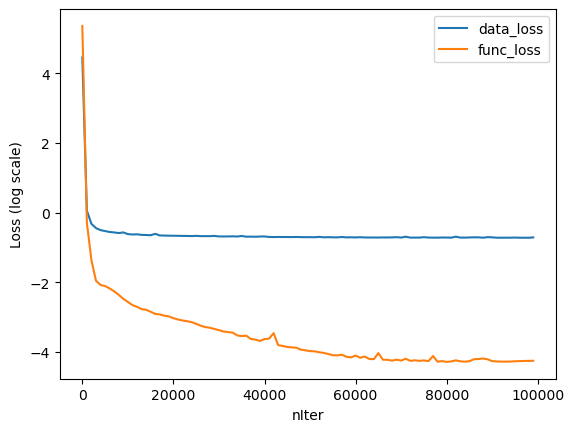

In [5]:
x         =  np.array(model.loss_history["nIter"])
data_loss = np.array(model.loss_history["data_loss"])
func_loss = np.array(model.loss_history["func_loss"])
plt.plot(x,np.log(data_loss),label='data_loss')
plt.plot(x,np.log(func_loss),label='func_loss')
plt.xlabel('nIter')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.show()

In [63]:
# Prediction
model.return_parameters( )
t_fit = np.arange(0,400,1)[:,np.newaxis]
T_n_star, T_s_star, T_d_star, N_n_star, N_s_star = model.predict(t_fit)

lambda_n  | [-0.76865846]
lambda_s  | [-0.9912185]
gamma_n   | [0.65623224]
gamma_s   | [0.7265334]
epsilon_n | [0.96301425]
epsilon_s | [2.6231527]
F_n       | [7.6092887]
F_s       | [7.6092887]
Q         | [0.31139848]
C_n       | [3.9827633]
C_s       | [9.092182]
C_d       | [170.68483]


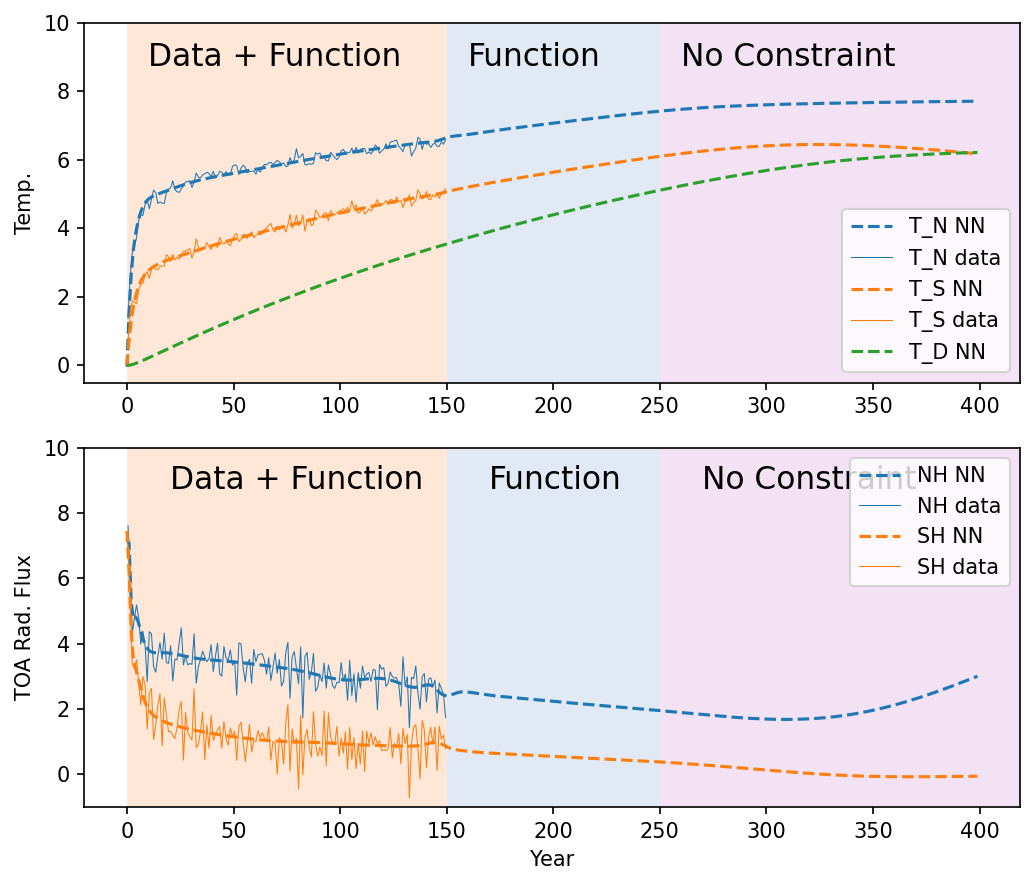

In [80]:
%matplotlib inline
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(7,6),dpi=150)
ax1 = plt.subplot(2,1,1)

# results
p = ax1.plot(t_fit, T_n_star, '--', label='T_N NN')
color_tmp = p[0].get_color()
ax1.plot(t_data,T_n,'-',color = color_tmp,linewidth=0.5, label='T_N data')
p = ax1.plot(t_fit, T_s_star, '--', label='T_S NN')
color_tmp = p[0].get_color()
ax1.plot(t_data,T_s,'-',color = color_tmp,linewidth=0.5,label='T_S data')
p = ax1.plot(t_fit, T_d_star, '--', label='T_D NN')
plt.ylim(-0.5,10)
# explaination
y_b = [-2,10]
x_b = [0,150,250,500]
shadow_boxes = [Rectangle((x_b[i], y_b[0]), x_b[i+1]-x_b[i], y_b[1]-y_b[0])
                for i in range(3)]
# Create patch collection with specified colour/alpha
pc = PatchCollection(shadow_boxes, facecolor=["#fee7d7","#e1e9f4","#f3e1f4"], 
                     alpha=1, edgecolor=None)
# Add collection to axes
ax1.add_collection(pc)

region_name = ['Data + Function','Function','No Constraint']
for i in range(3):
    plt.text(x_b[i]+10, 9, region_name[i], ha='left', va='center', fontsize=15)
ax1.legend()
# ax1.set_xlabel('Year')
ax1.set_ylabel('Temp.')


# results
ax1 = plt.subplot(2,1,2)
p = ax1.plot(t_fit, N_n_star, '--', label='NH NN')
color_tmp = p[0].get_color()
ax1.plot(t_data, N_n,'-',color = color_tmp,linewidth=0.5, label='NH data')
p = ax1.plot(t_fit,N_s_star, '--', label='SH NN')
color_tmp = p[0].get_color()
ax1.plot(t_data, N_s,'-',color = color_tmp,linewidth=0.5,label='SH data')
plt.ylim(-1,10)
ax1.legend()

# explaination
# Create patch collection with specified colour/alpha
pc = PatchCollection(shadow_boxes, facecolor=["#fee7d7","#e1e9f4","#f3e1f4"], 
                     alpha=1, edgecolor=None)
# Add collection to axes
ax1.add_collection(pc)

region_name = ['Data + Function','Function','No Constraint']
for i in range(3):
    plt.text(x_b[i]+20, 9, region_name[i], ha='left', va='center', fontsize=15)
ax1.set_xlabel('Year')
ax1.set_ylabel('TOA Rad. Flux')
fig.tight_layout()
fig.show()

